In [65]:
import numpy as np
import pandas as pd
from omegaconf import OmegaConf
from os.path import join, isdir, dirname, abspath
from os import listdir
from typing import List
from pathlib import Path
import boto3
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec
import matplotlib as mpl
from collections import OrderedDict
import torch
from scipy.stats import linregress

from matplotlib import colors


root_path = dirname(abspath("./"))
import sys
sys.path.append(root_path)

from prochain_transformer.subroutines.eval_sweeps import get_df_recursive, has_logs_subfolder, get_df_kfold_loss
from prochain_transformer.predict import get_features_gradients
from prochain_transformer.modules.utils import find_last_checkpoint
from prochain_transformer.experiment_control import update_config
from prochain_transformer.forecaster import TransformerForecaster

In [69]:
def post_process_sweep(
    df: pd.DataFrame,
    compound_cols: List[dict],
    columns_name_map: dict=None,
    columns_to_dump: list=None
    ):
    
    df_ = df.copy()
    
    # extract sweeps and base info
    for compound_col in compound_cols:
        df_[compound_col["new_label"]] = df_[compound_col["old_label"]].str.extract(compound_col["regex"])
        df_[compound_col["new_label"]] = df_[compound_col["new_label"]].astype(compound_col["type"])
        
    if columns_name_map is not None:
        df_ = df_.rename(columns=columns_name_map)
        
    if columns_to_dump is not None:
        df_ = df_.drop(columns=columns_to_dump)
        
    return df_

In [76]:
# load sensitivity dataframe
df_sens = pd.read_csv("../experiments/evaluations/dx_250618_sum/sensitivity/df_S")

# load loss dataframe
dirpath = "../experiments/training/dx_250618_sum"
df_loss = get_df_recursive(filepath=dirpath, bottom_action=get_df_kfold_loss, is_bottom= has_logs_subfolder)


columns_name_map_sens = {
    "feat0"  : "variable",
    "feat1"  : "position",
    "feat2"  : "value",
    "feat3"  : "time",
    "level_2": "sweep variable"
    }

columns_name_map_loss = {
    "val_loss"  : "validation",
    "train_loss"  : "train",
    "test_loss"  : "test",
    "level_2": "sweep variable"
    }

compound_cols_sens = [
        {
            "old_label":"level_3", 
            "new_label":"sweep value", 
            "regex":r"(\d+)$", 
            "type":float
            },
        {
            "old_label" :"level_0",
            "new_label": "model base",
            "regex":r"(\d+)$", 
            "type":float}
        ]

compound_cols_loss = [
        {
            "old_label":"level_3", 
            "new_label":"sweep value", 
            "regex":r"(\d+)$", 
            "type":float
            },
        {
            "old_label" :"level_0",
            "new_label": "model base",
            "regex":r"(\d+)$", 
            "type":float}
        ]

columns_to_dump = [
    "level_0",
    "level_1",
    "level_3"
]



df_S = post_process_sweep(df_sens, compound_cols_sens, columns_name_map_sens,columns_to_dump)
df_L = post_process_sweep(df_loss, compound_cols_loss, columns_name_map_loss, columns_to_dump)

# merge dataframes
index_columns = ["model base", "sweep variable", "sweep value", "k"]
df = pd.merge(df_L, df_S, on=index_columns, how='inner')
df.head()

,k,validation,train,test,sweep variable,sweep value,model base,Unnamed: 0,variable,position,value,time
0,k_0,0.007662,0.000402,0.000482,sweep_d_ff,10.0,100.0,0,0.000358,0.000358,0.000358,0.000358
1,k_1,0.005159,0.000239,0.000566,sweep_d_ff,10.0,100.0,1,0.000181,0.000181,0.000181,0.000181
2,k_2,0.008717,0.000343,0.004105,sweep_d_ff,10.0,100.0,2,0.000339,0.000339,0.000339,0.000339
3,k_3,0.007904,0.000170,0.003993,sweep_d_ff,10.0,100.0,3,0.000345,0.000345,0.000345,0.000345
4,k_4,0.005754,0.000404,0.004446,sweep_d_ff,10.0,100.0,4,0.000218,0.000218,0.000218,0.000218


In [77]:
df_test = df.set_index(["model base","sweep variable"]).loc[20].loc["sweep_d_model_set"].fillna(value=0)
df_test.head()

,k,validation,train,test,sweep value,Unnamed: 0,variable,position,value,time
sweep variable,,,,,,,,,,
sweep_d_model_set,k_0,0.006671,0.000333,0.000778,100.0,0,0.000139,0.000139,0.000139,0.000139
sweep_d_model_set,k_1,0.005037,0.000211,0.000584,100.0,1,0.000208,0.000208,0.000208,0.000208
sweep_d_model_set,k_2,0.008955,0.000400,0.005306,100.0,2,0.000246,0.000246,0.000246,0.000246
sweep_d_model_set,k_3,0.009599,0.000151,0.002261,100.0,3,0.000175,0.000175,0.000175,0.000175
sweep_d_model_set,k_4,0.004848,0.000395,0.007294,100.0,4,0.000210,0.000210,0.000210,0.000210


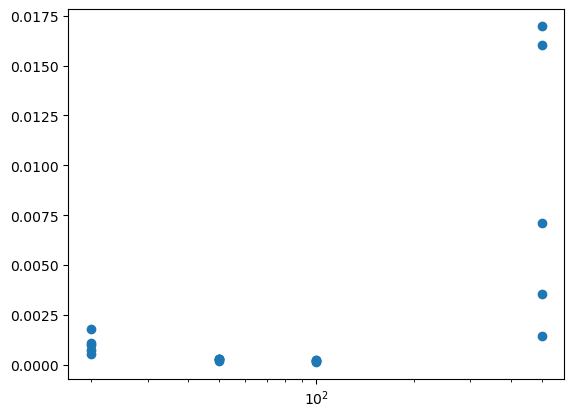

In [78]:
plt.scatter(df_test["sweep value"], df_test["time"])
plt.xscale("log")

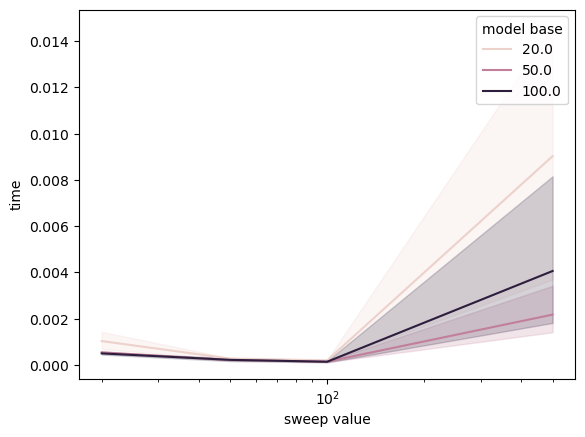

In [79]:
df_plot = df.set_index(["sweep variable"]).loc["sweep_d_model_set"].fillna(value=0)

sns.lineplot(df_plot, x="sweep value",y="time", hue="model base")
plt.xscale("log")

After 100, which is the maximum base dimension, we have $d_\text{embeddings}>d_\text{model}$. Il looks to be true that the feature attribution is proportional to the difference between model dimension and embedding dimension.
The variance blows up afterwards -> variance dominated regime = overfit

Also, why is it constant up to 100?

<Axes: xlabel='sweep value', ylabel='time'>

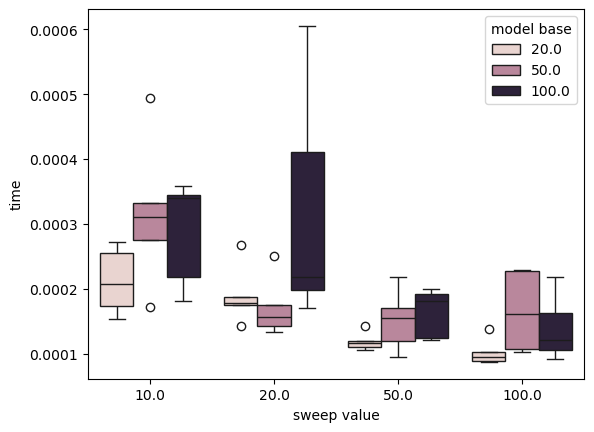

In [80]:
df_plot = df.set_index(["sweep variable"]).loc["sweep_d_ff"].fillna(value=0)

sns.boxplot(df_plot, x="sweep value",y="time", hue="model base")

# Loss

In [104]:
value_vars_loss = ["train","test","validation"]
id_vars_loss = [x for x in df.columns.tolist() if x not in value_vars_loss]
df_loss_melt = df.melt(id_vars=id_vars_loss, value_vars=value_vars_loss, var_name="dataset", value_name="loss")

<Axes: xlabel='sweep value', ylabel='loss'>

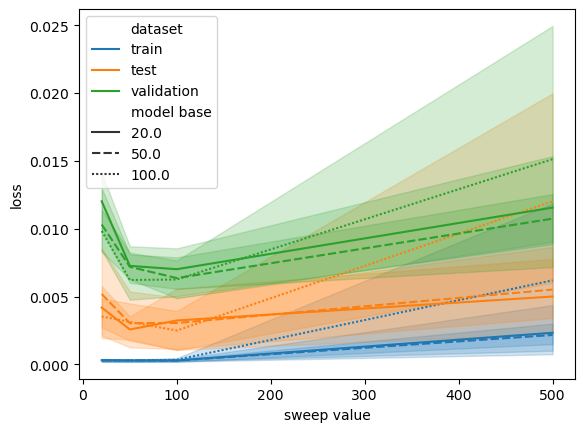

In [107]:
df_plot = df_loss_melt.set_index(["sweep variable"]).loc["sweep_d_model_set"].fillna(value=0)

sns.lineplot(df_plot, x="sweep value",y="loss", hue="dataset",style="model base")
#sns.lineplot(df_plot, x="sweep value",y="time", hue="model base")

<Axes: xlabel='sweep value', ylabel='time'>

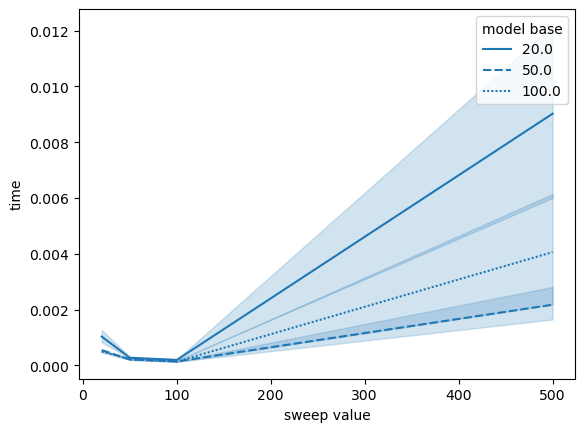

In [109]:
sns.lineplot(df_plot, x="sweep value",y="time", style="model base")

- For $d_\text{emb}>100$ we have underfit
- For $d_\text{emb}<50$ we have overfit

Consider the optimal $d_\text{emb}^\star=100$ it seems that $d_\text{emb}^\star\perp d_\text{model}$ --> $d_\text{model}$ doesn't help in broadening the region, it only affects the steepness. The size of the dataset remains a bottleneck for summed embeddings. 

Feature attribution is correlated to underfit (is it a small-dataset problem?). Why?

Todo:
include points 200, 300, 400